In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

# This is a hand-written digit recognition model


In [2]:
transform=v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5])
])

In [3]:
train_data = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.5], std=[0.5], inplace=False)
           )

In [5]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [6]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.5], std=[0.5], inplace=False)
           )

In [8]:
data_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, num_workers=1)

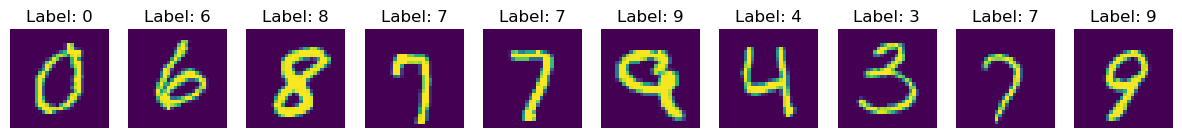

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Transpose the image to be in the correct format for matplotlib.
    plt.show()

images, labels = next(iter(data_loader))
fig, axs = plt.subplots(1, 10, figsize=(15, 15))

for i in range(10):
    axs[i].imshow(np.transpose((images[i] / 2 + 0.5).numpy(), (1, 2, 0)))
    axs[i].set_title(f'Label: {labels[i].item()}')
    axs[i].axis('off')

plt.show()

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 1 channel in, 10 filters out, 5x5 kernel.
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 10 channels in, 20 filters out, 5x5 kernel.
        self.conv2_drop = nn.Dropout2d() # Dropout layer. Randomly zeroes some of the elements of the input tensor with probability p.
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, 10) # 10 output classes corresponding to digits 0-9.

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # Max pooling layer with 2x2 kernel. This reduces the size of the image by half.
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # Dropout layer applied to the second convolutional layer.
        x = x.view(-1, 320) # Flatten the tensor.
        x = F.relu(self.fc1(x)) # Fully connected layer. ReLU activation function.
        x = F.dropout(x, training=self.training) # Dropout layer applied to the fully connected layer.
        x = self.fc2(x) # Fully connected layer. 
        return F.log_softmax(x, dim=1)

model = Net()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # By resetting the gradients to zero at the start of each training iteration, you ensure that the gradient values computed are only from the current batch of data.
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward() # Backpropagation. Computes the gradient of the loss with respect to all the model parameters.
        optimizer.step() # Optimizer. Updates the model parameters based on the gradients computed in the backward pass.
        if batch_idx % 25 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))

In [14]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [15]:
epoch = 100
for epoch in range(1, epoch + 1):
    train(epoch)
    test()

torch.save(model.state_dict(), "handwritten_text_recognition.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304371
Train Epoch: 1 [2500/60000 (4%)]	Loss: 1.927321
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.137645
Train Epoch: 1 [7500/60000 (12%)]	Loss: 0.922733
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.612230
Train Epoch: 1 [12500/60000 (21%)]	Loss: 0.606881
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.389708
Train Epoch: 1 [17500/60000 (29%)]	Loss: 0.452499
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.502810
Train Epoch: 1 [22500/60000 (38%)]	Loss: 0.335000
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.334037
Train Epoch: 1 [27500/60000 (46%)]	Loss: 0.382605
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.394727
Train Epoch: 1 [32500/60000 (54%)]	Loss: 0.173758
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.367988
Train Epoch: 1 [37500/60000 (62%)]	Loss: 0.410820
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.228746
Train Epoch: 1 [42500/60000 (71%)]	Loss: 0.182920
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.258795
Train Epoch: 1 [47500/60000 (79%)]	Loss: 0.311218
Train Epoc

Predicted: tensor([[8]])


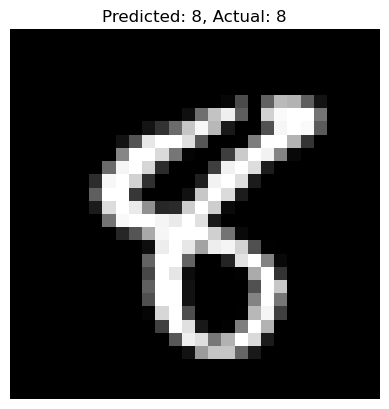

In [34]:
model.eval()

images, labels = test_data[84]
data = images.unsqueeze(0).to(device) # The batch size is 1 in this case.

output = model(data)
pred = output.argmax(dim=1, keepdim=True)

print('Predicted:', pred)

image = data.squeeze(0).squeeze(0).to(device).numpy()
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title(f'Predicted: {pred.item()}, Actual: {labels}')
plt.show()